In [131]:
from __future__ import print_function

import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt

import time

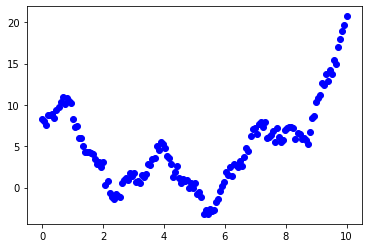

In [132]:
n = 150
X_data = np.linspace(0, 10, n)
X_data = X_data.reshape((n, 1))
# Y_data = np.sin(X_data)
Y_data = np.cos(X_data / 5)**3 + 4* np.sin(2 * X_data)**3 + \
.3 * (X_data - 5)**2 + 0.02 * (X_data - 2)**3 
# data_no_noise = np.concatenate((X_data, Y_data), axis=1)

Y_data += np.random.normal(0, 0.5, [n, 1])

plt.plot(X_data, Y_data, 'bo')
plt.show()

In [133]:
data = np.concatenate((X_data, Y_data), axis=1)

np.random.shuffle(data)

data_tr, data_val= np.split(data, [int(0.8*n)], axis = 0)
print(data_tr.shape, data_val.shape)
n_tr, n_val = data_tr.shape[0], data_val.shape[0]

(120, 2) (30, 2)


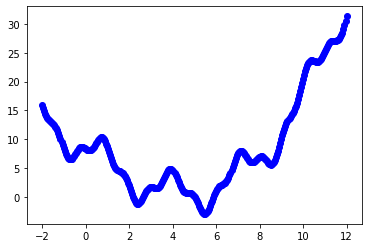

In [134]:
n_eval = 300
X_data = np.linspace(-2, 12, n_eval)
X_data = X_data.reshape((n_eval, 1))
# Y_data = np.sin(X_data)
Y_data = np.cos(X_data / 5)**3 + 4* np.sin(2 * X_data)**3 + \
.3 * (X_data - 5)**2 + 0.02 * (X_data - 2)**3 

plt.plot(X_data, Y_data, 'bo')
plt.show()

data_eval = np.concatenate((X_data, Y_data), axis=1)

In [135]:
def next_batch(data_tr, i, batch_size):
    return data_tr[i * batch_size:(i + 1) * batch_size - 1, :]  

In [160]:
# Parameters
num_epochs = 1
batches = 1
batch_size = n_tr // batches
itpep = n_tr // batch_size
# print(itpep)

# Network Parameters
n_hidden_1 = 512
n_hidden_2 = 512
num_input = 1 
num_output = 1 

# tf Graph input
X = tf.placeholder(tf.float32, shape = [None, 1])
Y = tf.placeholder(tf.float32, shape = [None, 1])

# Store layers weight & bias
weights = {
    'h1': tf.Variable(tf.random_normal([num_input, n_hidden_1])),
    'h2': tf.Variable(tf.random_normal([n_hidden_1, n_hidden_2])),
    'out': tf.Variable(tf.random_normal([n_hidden_2, num_output]))
}
biases = {
    'b1': tf.Variable(tf.random_normal([n_hidden_1])),
    'b2': tf.Variable(tf.random_normal([n_hidden_2])),
    'out': tf.Variable(tf.random_normal([num_output]))
}

# Create model
def neural_net(x):
    layer_1 = tf.nn.sigmoid(tf.add(tf.matmul(x, weights['h1']), biases['b1']))
    layer_2 = tf.nn.sigmoid(tf.add(tf.matmul(layer_1, weights['h2']), biases['b2']))
    out_layer = tf.add(tf.matmul(layer_2, weights['out']), biases['out'])
    return out_layer

fp = neural_net(X)
error = tf.reduce_sum(tf.pow(fp - Y, 2)) / tf.cast(tf.size(Y), float)

# wd_pars = np.linspace(0, 0.001, 3)
wd_pars = [0]
learning_rate = 0.005


In [158]:
tf.random.set_random_seed(seed = 5)

Optimization for lambda 0.000000 finished with validation error 100.548470


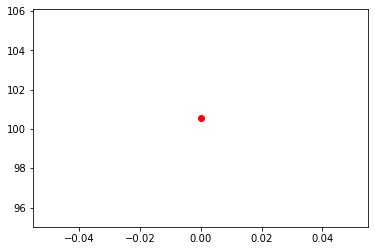

[654.3945, 156.59085]


In [165]:
optimizer = tf.train.AdamOptimizer(learning_rate = learning_rate)

wd_errors = []
opt_weights = []
opt_biases = []

sess = tf.Session()
for wd_par in wd_pars:
    loss = tf.reduce_sum(tf.pow(fp - Y, 2)) / tf.cast(tf.size(Y), float) \
                    + wd_par * tf.reduce_sum([tf.reduce_sum(tf.pow(weights[i], 2)) for i in weights])

    train_op = optimizer.minimize(loss)
    init = tf.global_variables_initializer()
    #############################################################
    sess.run(init)
    #############################################################   
    tr_loss = [sess.run(loss, feed_dict={X: data_tr[:, [0]], Y: data_tr[:, [1]]})]
    val_error = [sess.run(error, feed_dict={X: data_val[:, [0]], Y: data_val[:, [1]]})]
    #############################################################
    for iteration in range(num_epochs):
        for i in range(itpep):
            data_batch = next_batch(data_tr, i, batch_size)
            sess.run(train_op, feed_dict={X: data_batch[:, [0]], Y: data_batch[:, [1]]})
        tr_loss.append(sess.run(loss, feed_dict={X: data_tr[:, [0]], Y: data_tr[:, [1]]}))
        val_error.append(sess.run(error, feed_dict={X: data_val[:, [0]], Y: data_val[:, [1]]}))

    print('Optimization for lambda {:.6f} finished with validation error {:.6f}'.format(wd_par, val_error[-1]))
#     plt.yscale('log')
#     plt.plot(tr_loss)
#     plt.plot(val_error)
#     plt.show()
    
    wd_errors.append(sess.run(error, feed_dict={X: data_val[:, [0]], Y: data_val[:, [1]]}))
    opt_weights.append(sess.run(weights))
    opt_biases.append(sess.run(biases))

plt.plot(wd_pars, wd_errors, 'ro-')
plt.show()
print(tr_loss)

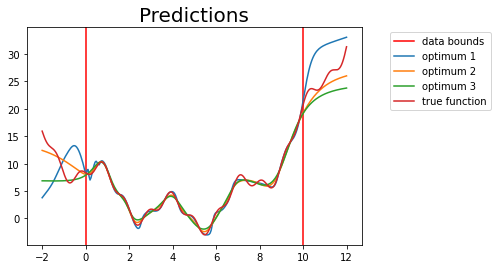

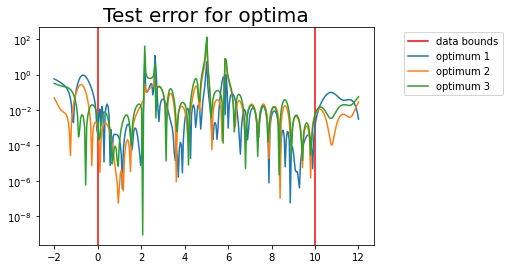

In [127]:
plt.title('Predictions', fontsize = 20)
plt.axvline(x = 0, label = 'data bounds', color = 'r')
plt.axvline(x = 10, color = 'r')
for c in range(len(opt_weights)):
    weights = opt_weights[c]
    biases = opt_biases[c]
    fp = neural_net(X)
    plt.plot(data_eval[:, [0]], sess.run(fp, feed_dict = {X: data_eval[:, [0]]}), label = 'optimum %.1d' %(c+1))
    
plt.plot(data_eval[:, [0]], data_eval[:, [1]], label = 'true function')
plt.legend(bbox_to_anchor=(1.4, 1.0))
plt.show()

plt.title('Test error for optima', fontsize = 20)
plt.yscale('log')
plt.axvline(x = 0, label = 'data bounds', color = 'r')
plt.axvline(x = 10, color = 'r')
ensemble = np.zeros(data_eval[:, [0]].shape)
for c in range(len(opt_weights)):
    weights = opt_weights[c]
    biases = opt_biases[c]
    fp = neural_net(X)
    temp_error = sess.run(tf.pow(fp - Y, 2) / tf.pow(Y, 2), feed_dict = {X: data_eval[:, [0]], Y: data_eval[:, [1]]})
    plt.plot(data_eval[:, [0]], temp_error, label = 'optimum %.1d' %(c+1))

plt.legend(bbox_to_anchor=(1.4, 1.0))
plt.show()

In [128]:
# Parameters
num_epochs = 4000
batches = 1
batch_size = n_tr // batches
itpep = n_tr // batch_size
# print(itpep)

# Network Parameters
n_hidden_1 = 512
n_hidden_2 = 512
num_input = 1 
num_output = 1 

# tf Graph input
X = tf.placeholder(tf.float32, shape = [None, 1])
Y = tf.placeholder(tf.float32, shape = [None, 1])

# Store layers weight & bias
weights = {
    'h1': tf.Variable(tf.random_normal([num_input, n_hidden_1])),
    'h2': tf.Variable(tf.random_normal([n_hidden_1, n_hidden_2])),
    'out': tf.Variable(tf.random_normal([n_hidden_2, num_output]))
}
biases = {
    'b1': tf.Variable(tf.random_normal([n_hidden_1])),
    'b2': tf.Variable(tf.random_normal([n_hidden_2])),
    'out': tf.Variable(tf.random_normal([num_output]))
}

# Create model
def neural_net(x):
    layer_1 = tf.nn.sigmoid(tf.add(tf.matmul(x, weights['h1']), biases['b1']))
    layer_2 = tf.nn.sigmoid(tf.add(tf.matmul(layer_1, weights['h2']), biases['b2']))
    out_layer = tf.add(tf.matmul(layer_2, weights['out']), biases['out'])
    return out_layer

fp = neural_net(X)
error = tf.reduce_sum(tf.pow(fp - Y, 2)) / tf.cast(tf.size(Y), float)

wd_par = 0.0
lrs = np.linspace(0.01, 0.05, 3)

loss = tf.reduce_sum(tf.pow(fp - Y, 2)) / tf.cast(tf.size(Y), float) \
                + wd_par * tf.reduce_sum([tf.reduce_sum(tf.pow(weights[i], 2)) for i in weights])

train_op = optimizer.minimize(loss)

Optimization for lambda 0.000000 finished with validation error 0.418751


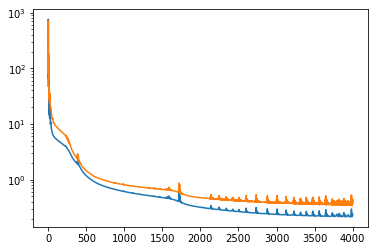

Optimization for lambda 0.000000 finished with validation error 2.338890


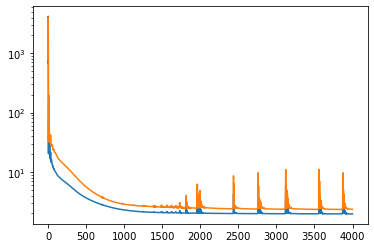

Optimization for lambda 0.000000 finished with validation error 35.531956


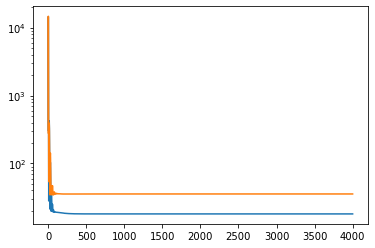

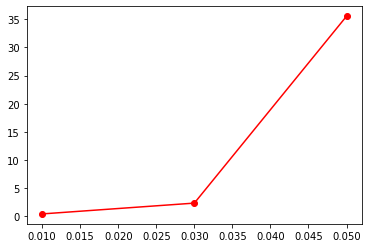

In [129]:
lr_errors = []
opt_weights = []
opt_biases = []

sess = tf.Session()
for lr in lrs:
    optimizer = tf.train.AdamOptimizer(learning_rate = lr)
    train_op = optimizer.minimize(loss)
    init = tf.global_variables_initializer()
    #############################################################
    sess.run(init)
    #############################################################   
    tr_loss = [sess.run(loss, feed_dict={X: data_tr[:, [0]], Y: data_tr[:, [1]]})]
    val_error = [sess.run(error, feed_dict={X: data_val[:, [0]], Y: data_val[:, [1]]})]
    #############################################################
    for iteration in range(num_epochs):
        for i in range(itpep):
            data_batch = next_batch(data_tr, i, batch_size)
            sess.run(train_op, feed_dict={X: data_batch[:, [0]], Y: data_batch[:, [1]]})
        tr_loss.append(sess.run(loss, feed_dict={X: data_tr[:, [0]], Y: data_tr[:, [1]]}))
        val_error.append(sess.run(error, feed_dict={X: data_val[:, [0]], Y: data_val[:, [1]]}))

    print('Optimization for lambda {:.6f} finished with validation error {:.6f}'.format(wd_par, val_error[-1]))
    plt.yscale('log')
    plt.plot(tr_loss)
    plt.plot(val_error)
    plt.show()
    
    lr_errors.append(sess.run(error, feed_dict={X: data_val[:, [0]], Y: data_val[:, [1]]}))
    opt_weights.append(sess.run(weights))
    opt_biases.append(sess.run(biases))

plt.plot(lrs, lr_errors, 'ro-')
plt.show()

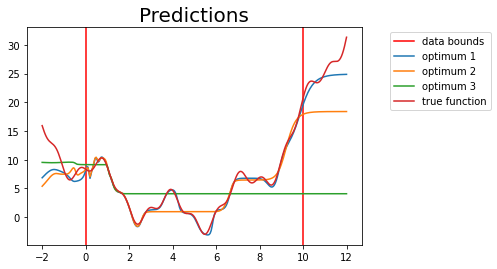

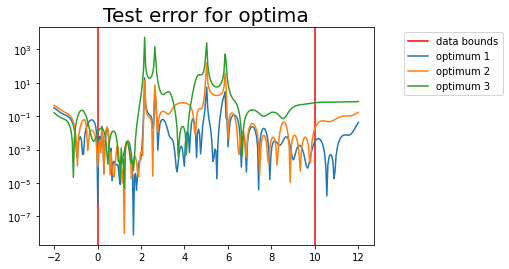

In [130]:
plt.title('Predictions', fontsize = 20)
plt.axvline(x = 0, label = 'data bounds', color = 'r')
plt.axvline(x = 10, color = 'r')
for c in range(len(opt_weights)):
    weights = opt_weights[c]
    biases = opt_biases[c]
    fp = neural_net(X)
    plt.plot(data_eval[:, [0]], sess.run(fp, feed_dict = {X: data_eval[:, [0]]}), label = 'optimum %.1d' %(c+1))
    
plt.plot(data_eval[:, [0]], data_eval[:, [1]], label = 'true function')
plt.legend(bbox_to_anchor=(1.4, 1.0))
plt.show()

plt.title('Test error for optima', fontsize = 20)
plt.yscale('log')
plt.axvline(x = 0, label = 'data bounds', color = 'r')
plt.axvline(x = 10, color = 'r')
ensemble = np.zeros(data_eval[:, [0]].shape)
for c in range(len(opt_weights)):
    weights = opt_weights[c]
    biases = opt_biases[c]
    fp = neural_net(X)
    temp_error = sess.run(tf.pow(fp - Y, 2) / tf.pow(Y, 2), feed_dict = {X: data_eval[:, [0]], Y: data_eval[:, [1]]})
    plt.plot(data_eval[:, [0]], temp_error, label = 'optimum %.1d' %(c+1))

plt.legend(bbox_to_anchor=(1.4, 1.0))
plt.show()